In [ ]:
#Import the library

import pandas as pd
import numpy as np
import random
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import time
import pandas as pd

import time
import matplotlib.pyplot as plt
import itertools

In [ ]:
#Reading the data
def read_dat_data(path):


 mydata = pd.read_csv(path, delimiter="::", header=0)
 mydata = mydata.drop(mydata.index[-1])
 mydata.columns=['user_id', 'movie_id','rating','timestamp']

 return(mydata)




def read_csv_data(path):


  mydata = pd.read_csv(path, delimiter=",")
  mydata.columns=['user_id', 'movie_id','rating','timestamp']

  return(mydata)



mydata=read_csv_data("/home/ahmedaa/Desktop/ml-32m/ratings.csv")



In [ ]:

#Creating lists and dividing the data into training and testing
users=mydata['user_id']
movies=mydata['movie_id']
n=len(users.unique())
m=len(movies.unique())



tic = time.time()



map_user_to_index = dict(zip(mydata['user_id'].unique(), range(len(mydata))))
map_movie_to_index = dict(zip(mydata['movie_id'].unique(), range(len(mydata))))

train_data_by_user_index = [[] for _ in range(len(map_user_to_index))]
test_data_by_user_index=[[] for _ in range(len(map_user_to_index))]


train_data_by_movie_index = [[] for _ in range(len(map_movie_to_index))]
test_data_by_movie_index=[[] for _ in range(len(map_movie_to_index))]



for _, userId, movieId, rating, _ in mydata.itertuples():
    r = np.random.uniform(size=1)[0]
    if(r<0.90):
     train_data_by_user_index[map_user_to_index[userId]].append((movieId,rating))
     train_data_by_movie_index[map_movie_to_index[movieId]].append((userId,rating))
    else:
     test_data_by_user_index[map_user_to_index[userId]].append((movieId,rating))
     test_data_by_movie_index[map_movie_to_index[movieId]].append((userId,rating))


print("Donee")



toc = time.time()

# Calculate elapsed time
elapsed_time = toc - tic
print(f"Elapsed time: {elapsed_time:.2f} seconds")



In [ ]:
#Degree distribution plot
import matplotlib.pyplot as plt
import numpy as np

movies_degrees = Counter(movies)
movies_degrees_frequency=Counter(movies_degrees.values())



users_degrees = Counter(users)
users_degrees_frequency=Counter(users_degrees.values())

x_movies = np.log10(list(movies_degrees_frequency.keys()))
y_movies = np.log10(list(movies_degrees_frequency.values()))


x_users = np.log10(list(users_degrees_frequency.keys()))
y_users = np.log10(list(users_degrees_frequency.values()))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x_movies, y_movies, color='blue', label='Movies', alpha=0.7)
plt.scatter(x_users, y_users, color='red', label='Users', alpha=0.7)

# Add labels, title, and legend
plt.xlabel('Log(Degree)')
plt.ylabel('Log(Frequency)')
plt.title('Log-Log Degree Distribution for Movies and Users')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('degree_distribution.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:

#ratings tistribution
ratings = mydata['rating']

bins = np.arange(1, 5 + 2)  
# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(ratings, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)

# Adding labels and title
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Ratings Distribution')
plt.xticks(bins)  # Set x-axis ticks to match the bin edges
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Save the plot as a PDF file
plt.savefig('ratings_distribution.pdf', format='pdf', bbox_inches='tight')

# Display the plot
plt.show()


In [ ]:
#Vectorized biases only

import matplotlib.pyplot as plt
import numpy as np
import time

def initialize_biases_matrices(n, m):

    user_biases = np.zeros(n)
    item_biases = np.zeros(m)
    return user_biases, item_biases

def update_user_biases(user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index):
    for i, rated_by_user in enumerate(train_data_by_user_index):
        if len(rated_by_user) == 0:
            continue

        movie_indices = [map_movie_to_index[movie_id] for movie_id, _ in rated_by_user]
        ratings = np.array([rating for _, rating in rated_by_user])
        user_biases[i] = np.sum(lambdaa * (ratings - item_biases[movie_indices])) / (lambdaa * len(rated_by_user) + gamma)


def update_item_biases(user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index):
    for j, watched_by_users in enumerate(train_data_by_movie_index):
        if len(watched_by_users) == 0:
            continue

        user_indices = [map_user_to_index[user_id] for user_id, _ in watched_by_users]
        ratings = np.array([rating for _, rating in watched_by_users])
        item_biases[j] = np.sum(lambdaa * (ratings - user_biases[user_indices])) / (lambdaa * len(watched_by_users) + gamma)



def compute_metrics(user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma):
    RMSE = 0
    C = 0
    counter = 0

    for i, test_data in enumerate(test_data_by_user_index):
        if len(test_data) == 0:
            continue

        movie_indices = [map_movie_to_index[movie_id] for movie_id, _ in test_data]
        ratings = np.array([rating for _, rating in test_data])
        preds = user_biases[i] + item_biases[movie_indices]
        residuals = ratings - preds

        RMSE += np.sum(residuals**2)
        C -= 0.5 * gamma * (np.sum(residuals**2) + np.sum(user_biases[i]**2) + np.sum(item_biases[movie_indices]**2))
        counter += len(test_data)

    return (RMSE / counter)**0.5, C



def train_biases_model_with_rmse_plot(iterations, n, m, train_data_by_user_index, train_data_by_movie_index,
                                      test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau, pdf_filename="rmse_plot.pdf"):
    user_biases, item_biases = initialize_biases_matrices(n, m)
    train_RMSES = np.zeros(iterations)
    test_RMSES = np.zeros(iterations)

    tic = time.time()
    for r in range(iterations):
        print(f"Iteration {r + 1}/{iterations}")
        update_user_biases(user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index)
        update_item_biases(user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index)

        # Compute RMSE for training and testing
        train_RMSE, _ = compute_metrics(user_biases, item_biases, train_data_by_user_index, map_movie_to_index, gamma)
        test_RMSE, _ = compute_metrics(user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma)

        train_RMSES[r] = train_RMSE
        test_RMSES[r] = test_RMSE

        elapsed_time = time.time() - tic
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        print(f"Iteration {r + 1} Train RMSE: {train_RMSE:.4f}, Test RMSE: {test_RMSE:.4f}")

    print("Training complete!")

    # Plot RMSE for training and testing
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(train_RMSES)), train_RMSES, label="Training RMSE", color="blue")
    plt.plot(range(len(test_RMSES)), test_RMSES, label="Testing RMSE", color="orange")
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.title("Training and Testing RMSE Over Iterations(Only biases)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)

    # Save the plot as a PDF
    plt.savefig("biases_only_rmses_train_test.pdf", format='pdf')
    print(f"Plot saved as {pdf_filename}")

    # Display the plot
    plt.show()

    return user_biases, item_biases, train_RMSES, test_RMSES


def train_biases_model(iterations, n, m, train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau):
    user_biases, item_biases = initialize_biases_matrices(n, m)
    costs = np.zeros(iterations)
    RMSES = np.zeros(iterations)

    tic = time.time()
    for r in range(iterations):
        print(f"Iteration {r + 1}/{iterations}")
        update_user_biases(user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index)
        update_item_biases(user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index)

        RMSE, C = compute_metrics(user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma)
        costs[r] = C
        RMSES[r] = RMSE

        elapsed_time = time.time() - tic
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        print(f"Iteration {r + 1} RMSE: {RMSE:.4f}")

    print("Training complete!")
    plt.plot(range(len(RMSES)), RMSES)
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.title("RMSE Over Iterations")
    plt.show()
    return user_biases, item_biases, RMSES, costs




lambdaa=0.01
gamma=0.001
tau=0.1
k=10
user_biases , item_biases, RMSES,costs = train_biases_model_with_rmse_plot(iterations=10, n=n, m=m, train_data_by_user_index=train_data_by_user_index, train_data_by_movie_index=train_data_by_movie_index, test_data_by_user_index=test_data_by_user_index, map_movie_to_index=map_movie_to_index, map_user_to_index=map_user_to_index, lambdaa=lambdaa, gamma=gamma, tau=tau)


In [ ]:
#negative loss and rmse

def train_model(iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index,
                test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau):
    # Initialize matrices
    U, V, user_biases, item_biases = initialize_matrices(n, m, k)
    train_costs = np.zeros(iterations)
    test_costs = np.zeros(iterations)
    train_RMSES = np.zeros(iterations)
    test_RMSES = np.zeros(iterations)

    tic = time.time()
    for r in range(iterations):
        print(f"Iteration {r + 1}/{iterations}")

        # Update biases and factors
        update_user_biases(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index)
        update_user_factors(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, tau, map_movie_to_index, k)
        update_item_biases(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index)
        update_item_factors(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, tau, map_user_to_index, k)

        # Compute metrics for training and testing data
        train_RMSE, train_C = compute_metrics(U, V, user_biases, item_biases, train_data_by_user_index, map_movie_to_index, gamma)
        test_RMSE, test_C = compute_metrics(U, V, user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma)

        train_costs[r] = train_C
        test_costs[r] = test_C
        train_RMSES[r] = train_RMSE
        test_RMSES[r] = test_RMSE

        elapsed_time = time.time() - tic
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        print(f"Iteration {r + 1} Train RMSE: {train_RMSE:.4f}, Test RMSE: {test_RMSE:.4f}")

    print("Training complete!")

    # Plot RMSE over iterations
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(train_RMSES)), train_RMSES, label="Training RMSE", color="blue")
    plt.plot(range(len(test_RMSES)), test_RMSES, label="Testing RMSE", color="orange")
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.title("Training and Testing RMSE Over Iterations")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.savefig("full_rmse_plot_train_test.pdf", format="pdf")  # Save RMSE plot as PDF
    plt.show()
    print("RMSE plot saved as 'rmse_plot.pdf'.")
    plt.close()  # Close the figure to avoid overlap

    # Plot negative loss over iterations
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(train_costs)), -train_costs, label="Training Negative Loss", color="green")
    plt.plot(range(len(test_costs)), -test_costs, label="Testing Negative Loss", color="red")
    plt.xlabel("Iterations")
    plt.ylabel("Negative Loss")
    plt.title("Training and Testing Negative Loss Over Iterations")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.savefig("full_negative_loss_plot_train_test.pdf", format="pdf")  # Save Negative Loss plot as PDF
    print("Negative loss plot saved as 'negative_loss_plot.pdf'.")
    plt.show()
    plt.close()  # Close the figure to avoid overlap

    return U, V, user_biases, item_biases, train_RMSES, test_RMSES, train_costs, test_costs

# Example usage (assuming data and mappings are provided):
# train_model(iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau)






lambdaa=0.01
gamma=0.001
tau=0.1
k=10
U, V, user_biases, item_biases, train_RMSES, test_RMSES, train_costs, test_costs= train_model(iterations=10, n=n, m=m, k=k, train_data_by_user_index=train_data_by_user_index, train_data_by_movie_index=train_data_by_movie_index, test_data_by_user_index=test_data_by_user_index, map_movie_to_index=map_movie_to_index, map_user_to_index=map_user_to_index, lambdaa=lambdaa, gamma=gamma, tau=tau)


In [ ]:
#Vectorized general model

import matplotlib.pyplot as plt
import numpy as np
import time

def initialize_matrices(n, m, k):
    U = np.random.normal(0, 1/(k**0.5), (n, k))
    V = np.random.normal(0, 1/(k**0.5), (m, k))
    user_biases = np.zeros(n)
    item_biases = np.zeros(m)
    return U, V, user_biases, item_biases

def update_user_biases(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index):
    for i, rated_by_user in enumerate(train_data_by_user_index):
        if len(rated_by_user) == 0:
            continue

        movie_indices = [map_movie_to_index[movie_id] for movie_id, _ in rated_by_user]
        ratings = np.array([rating for _, rating in rated_by_user])
        V_rated = V[movie_indices]
        preds = np.sum(U[i] * V_rated, axis=1) + item_biases[movie_indices]
        residuals = ratings - preds

        user_biases[i] = np.sum(lambdaa * residuals) / (lambdaa * len(rated_by_user) + gamma)

def update_user_factors(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, tau, map_movie_to_index, k):
    I = tau * np.eye(k)
    for i, rated_by_user in enumerate(train_data_by_user_index):
        if len(rated_by_user) == 0:
            continue

        movie_indices = [map_movie_to_index[movie_id] for movie_id, _ in rated_by_user]
        ratings = np.array([rating for _, rating in rated_by_user])
        V_rated = V[movie_indices]

        residuals = ratings - user_biases[i] - item_biases[movie_indices]
        S = lambdaa * V_rated.T @ V_rated
        R = lambdaa * V_rated.T @ residuals[:, np.newaxis]

        U[i] = np.linalg.solve(S + I, R).flatten()

def update_item_biases(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index):
    for j, watched_by_users in enumerate(train_data_by_movie_index):
        if len(watched_by_users) == 0:
            continue

        user_indices = [map_user_to_index[user_id] for user_id, _ in watched_by_users]
        ratings = np.array([rating for _, rating in watched_by_users])
        U_rated = U[user_indices]
        preds = np.sum(U_rated * V[j], axis=1) + user_biases[user_indices]
        residuals = ratings - preds

        item_biases[j] = np.sum(lambdaa * residuals) / (lambdaa * len(watched_by_users) + gamma)

def update_item_factors(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, tau, map_user_to_index, k):
    I = tau * np.eye(k)
    for j, watched_by_users in enumerate(train_data_by_movie_index):
        if len(watched_by_users) == 0:
            continue

        user_indices = [map_user_to_index[user_id] for user_id, _ in watched_by_users]
        ratings = np.array([rating for _, rating in watched_by_users])
        U_rated = U[user_indices]

        residuals = ratings - user_biases[user_indices] - item_biases[j]
        S = lambdaa * U_rated.T @ U_rated
        R = lambdaa * U_rated.T @ residuals[:, np.newaxis]

        V[j] = np.linalg.solve(S + I, R).flatten()

def compute_metrics(U, V, user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma):
    RMSE = 0
    C = 0
    counter = 0

    for i, test_data in enumerate(test_data_by_user_index):
        if len(test_data) == 0:
            continue

        movie_indices = [map_movie_to_index[movie_id] for movie_id, _ in test_data]
        ratings = np.array([rating for _, rating in test_data])
        preds = np.sum(U[i] * V[movie_indices], axis=1) + user_biases[i] + item_biases[movie_indices]
        residuals = ratings - preds

        RMSE += np.sum(residuals**2)
        C -= 0.5 * gamma * (np.sum(residuals**2) + np.sum(user_biases[i]**2) + np.sum(item_biases[movie_indices]**2))
        counter += len(test_data)

    return (RMSE / counter)**0.5, C

def train_model(iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau):
    U, V, user_biases, item_biases = initialize_matrices(n, m, k)
    costs = np.zeros(iterations)
    RMSES = np.zeros(iterations)

    tic = time.time()
    for r in range(iterations):
        print(f"Iteration {r + 1}/{iterations}")
        update_user_biases(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index)
        update_user_factors(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, tau, map_movie_to_index, k)
        update_item_biases(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index)
        update_item_factors(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, tau, map_user_to_index, k)

        RMSE, C = compute_metrics(U, V, user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma)
        costs[r] = C
        RMSES[r] = RMSE

        elapsed_time = time.time() - tic
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        print(f"Iteration {r + 1} RMSE: {RMSE:.4f}")

    print("Training complete!")
    plt.plot(range(len(RMSES)), RMSES)
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.title("RMSE Over Iterations")
    plt.show()
    return U, V, user_biases, item_biases, RMSES, costs



lambdaa=0.01
gamma=0.001
tau=0.1
k=10

U, V, user_biases, item_biases, RMSES,costs = train_model(iterations=10, n=n, m=m, k=k, train_data_by_user_index=train_data_by_user_index, train_data_by_movie_index=train_data_by_movie_index, test_data_by_user_index=test_data_by_user_index, map_movie_to_index=map_movie_to_index, map_user_to_index=map_user_to_index, lambdaa=lambdaa, gamma=gamma, tau=tau)



In [ ]:
 # Plot RMSE over iterations
plt.figure(figsize=(8, 6))
plt.plot(range(len(RMSES)), RMSES, label="Testing RMSE", color="blue")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("Testing RMSE Over Iterations")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig("15_iterations.pdf", format="pdf")  # Save RMSE plot as PDF
plt.show()
print("RMSE plot saved as 'rmse_plot.pdf'.")
plt.close()  # Close the figure to avoid overlap

In [ ]:
#Grid seach on the hyberparameters
def grid_search(train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index,
                map_movie_to_index, map_user_to_index, n, m, k, iterations, lambdaa_values, gamma_values, tau_values):
   
    results = []
    best_config = None
    best_test_RMSE = float('inf')

    for lambdaa in lambdaa_values:
        for gamma in gamma_values:
            for tau in tau_values:
                print(f"Testing configuration: lambdaa={lambdaa}, gamma={gamma}, tau={tau}")

                # Train the model with the current hyperparameters
                U, V, user_biases, item_biases, test_RMSES, costs= train_model(
                    iterations, n, m, k,
                    train_data_by_user_index, train_data_by_movie_index,
                    test_data_by_user_index,
                    map_movie_to_index, map_user_to_index,
                    lambdaa, gamma, tau
                )

                # Get the RMSE for the last iteration
                final_test_RMSE = test_RMSES[-1]
                results.append((lambdaa, gamma, tau, final_test_RMSE))

                # Update the best configuration if necessary
                if final_test_RMSE < best_test_RMSE:
                    best_test_RMSE = final_test_RMSE
                    best_config = (lambdaa, gamma, tau)

                print(f"Final test RMSE for this configuration: {final_test_RMSE:.4f}")

    print(f"Best configuration: lambdaa={best_config[0]}, gamma={best_config[1]}, tau={best_config[2]} with RMSE={best_test_RMSE:.4f}")
    return results, best_config

# Example usage:
lambdaa_values = [0.001, 0.01, 0.1]
gamma_values = [0.001, 0.01, 0.1]
tau_values = [0.001, 0.01, 0.1]
iterations=10
# Perform the grid search
results, best_config = grid_search(
    train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index,
    map_movie_to_index, map_user_to_index, n, m, k, iterations,
    lambdaa_values, gamma_values, tau_values
)

# Display all results
print("All Results:")
for lambdaa, gamma, tau, test_RMSE in results:
    print(f"lambdaa={lambdaa}, gamma={gamma}, tau={tau} -> Test RMSE={test_RMSE:.4f}")


In [ ]:
def train_models_and_plot_rmse_vs_k(n, m, iterations, k_values, train_data_by_user_index, train_data_by_movie_index,
                                    test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau):
   
    test_rmse_per_k = {}

    for k in k_values:
        print(f"\nTraining model with k={k} latent factors...")
        # Adjusted to match the actual number of returned values
        U, V, user_biases, item_biases, test_RMSES, costs = train_model(
            iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index,
            test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau
        )
        # Use the last RMSE from train_RMSES (assuming this is test RMSE in your setup)
        final_test_rmse = test_RMSES[-1]
        test_rmse_per_k[k] = final_test_rmse
        print(f"Final Test RMSE for k={k}: {final_test_rmse:.4f}")

    # Plot Test RMSE vs. k
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, [test_rmse_per_k[k] for k in k_values], marker='o', color='blue', label="Test RMSE")
    plt.xlabel("Number of Latent Factors (k)")
    plt.ylabel("Test RMSE")
    plt.title("Test RMSE vs. Number of Latent Factors (k)")
    plt.grid()
    plt.legend()
    plt.savefig("test_rmse_vs_k.pdf")  # Save the plot as a PDF
    plt.show()

    return test_rmse_per_k




iterations = 10
k_values = [2, 4,8,16,32]  # Different values of k to test
lambdaa = 0.01
gamma = 0.001
tau = 0.1

# Train models with different values of k and plot RMSE vs. k
test_rmse_results = train_models_and_plot_rmse_vs_k(
    n, m, iterations, k_values,
    train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index,
    map_movie_to_index, map_user_to_index, lambdaa, gamma, tau
)

# Display results
print("\nTest RMSE for Different Values of k:")
for k, test_rmse in test_rmse_results.items():
    print(f"k={k}: Test RMSE={test_rmse:.4f}")



In [24]:


#Emmbedings 2D visualization

def count_ratings_by_movie(ratings_df):
    # Count ratings for each movie_id
    return ratings_df.groupby('movie_id').size()

# Read movies data
file_path = "/home/ahmedaa/Desktop/ml-32m/movies.csv"



movies_df = pd.read_csv(file_path, names=['movie_id', 'title', 'genres'], header=0)
movies_df["genres"] = movies_df["genres"].str.split("|")

child_mask = movies_df["genres"].apply(lambda genres: "Children" in genres)
drama_mask = movies_df["genres"].apply(lambda genres: "Drama" in genres)
documentary_mask = movies_df["genres"].apply(lambda genres: "Documentary" in genres)

child_animation_movies = movies_df[child_mask]
drama_movies = movies_df[drama_mask]
documentary_movies = movies_df[documentary_mask]

ratings_count = count_ratings_by_movie(mydata)

child_indx = child_animation_movies[child_animation_movies["movie_id"].isin(ratings_count[ratings_count > 100].index)]
drama_indx = drama_movies[drama_movies["movie_id"].isin(ratings_count[ratings_count > 100].index)]
documentary_indx = documentary_movies[documentary_movies["movie_id"].isin(ratings_count[ratings_count > 100].index)]

child_indx = child_indx["movie_id"].map(map_movie_to_index).tolist()
drama_indx = drama_indx["movie_id"].map(map_movie_to_index).tolist()
documentary_indx = documentary_indx["movie_id"].map(map_movie_to_index).tolist()


Scatter plot grid saved as 'scatterplot_grid.pdf'.


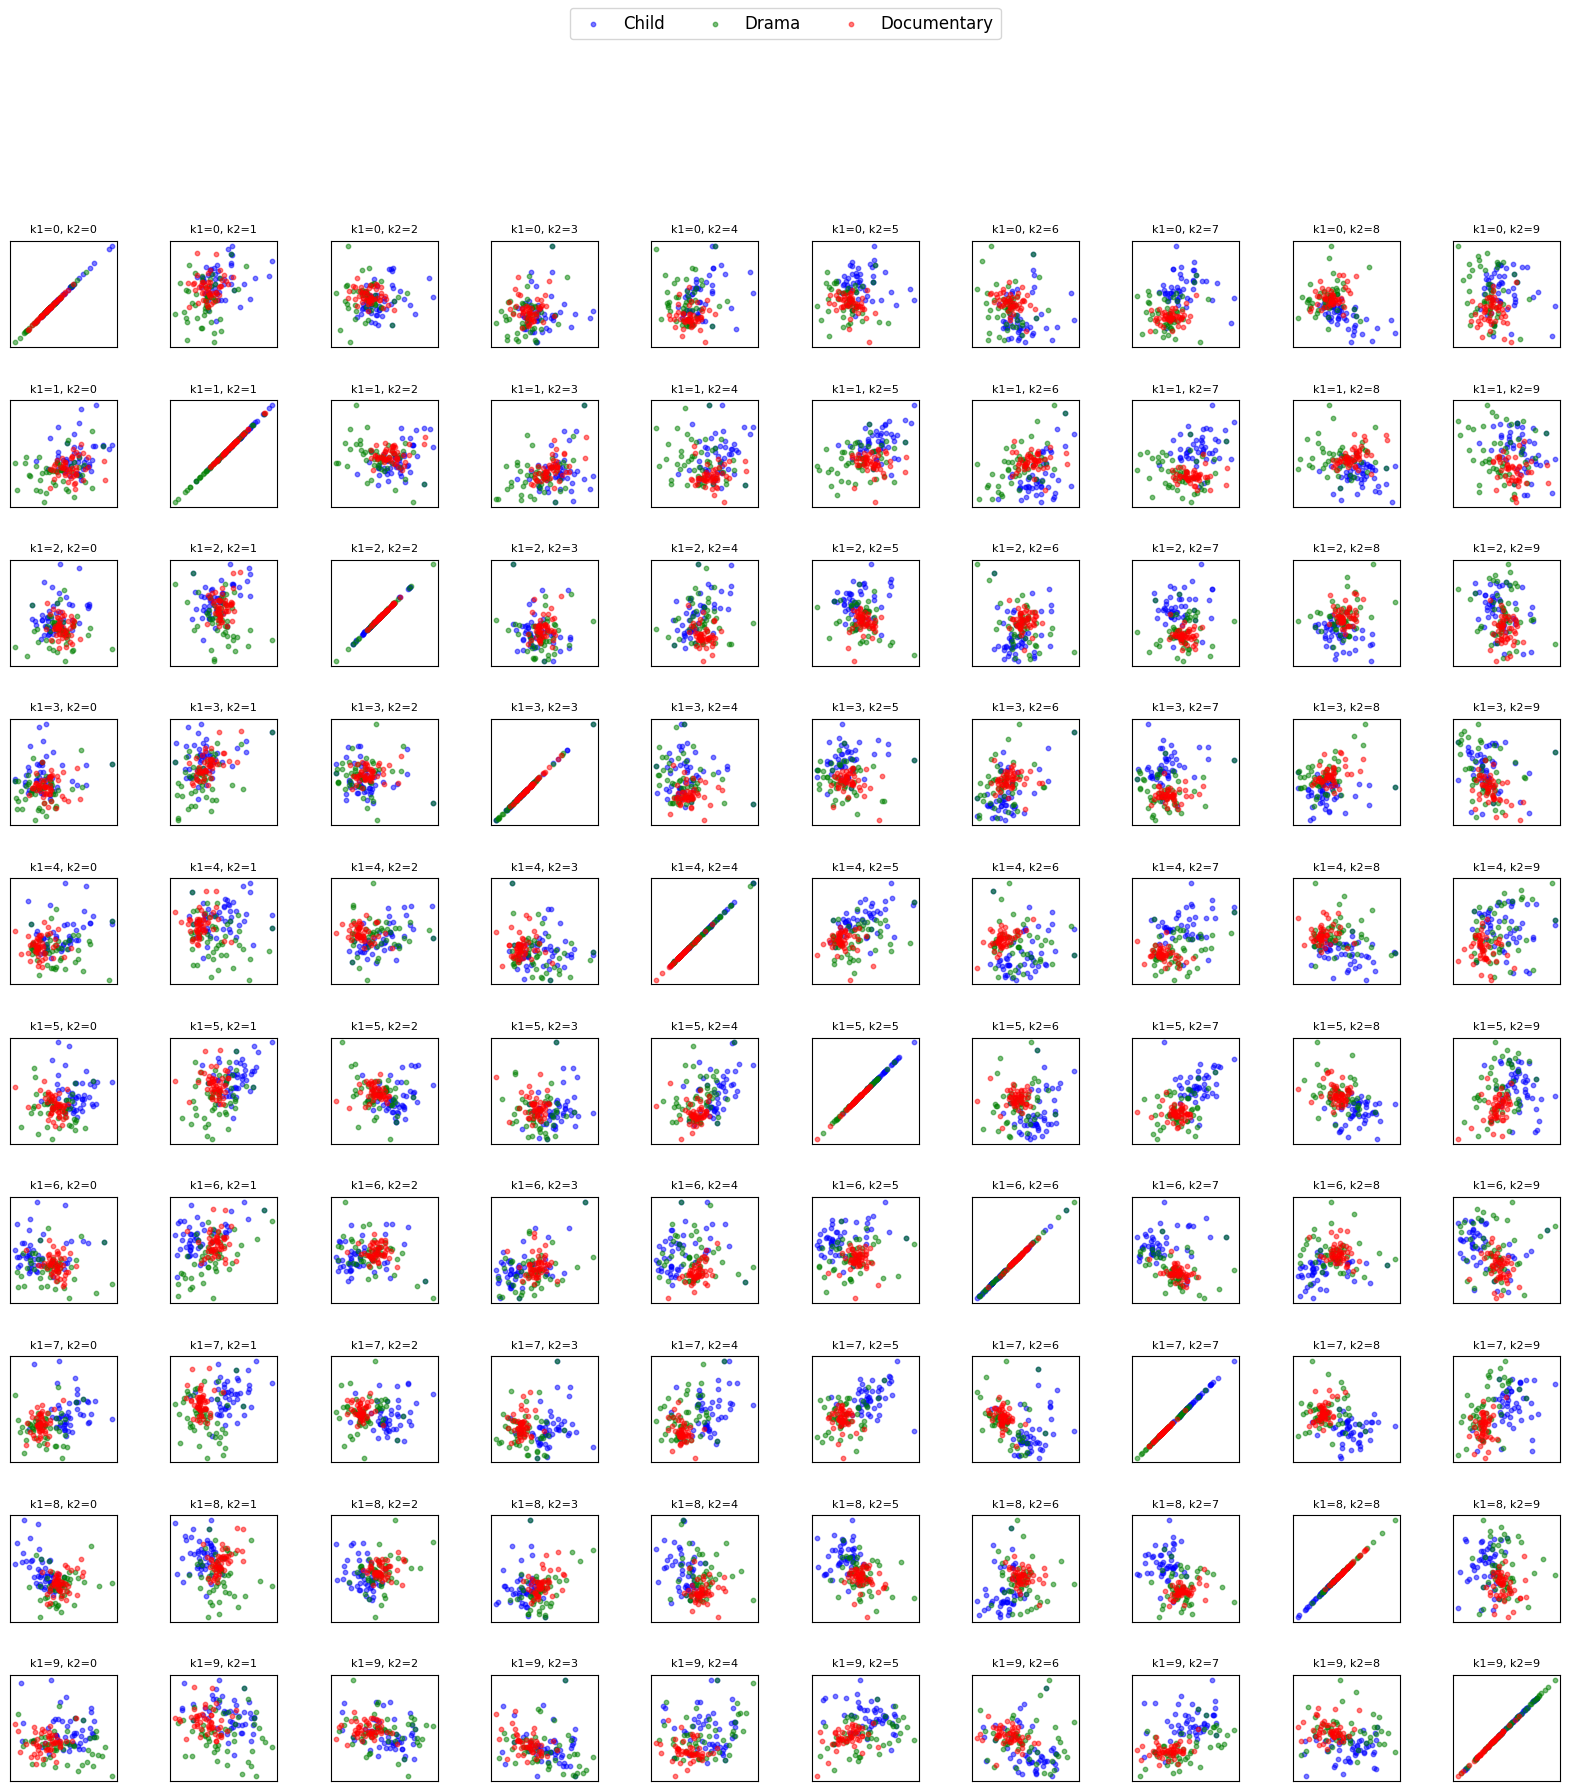

In [26]:


# Parameters
k_values = range(10)  # k1 and k2 values from 0 to 9
pairs = list(itertools.product(k_values, k_values))  # Generate all pairs of k1, k2

# Initialize lists for categories
cf1, cf2 = [], []
drf1, drf2 = [], []
df1, df2 = [], []

# Collect data for child, drama, and documentary categories
for i in range(50):
    cf1.append(V[child_indx[i]])
    drf1.append(V[drama_indx[i]])
    df1.append(V[documentary_indx[i]])

# Convert to numpy arrays for easier indexing
cf1, drf1, df1 = map(np.array, [cf1, drf1, df1])

# Grid size
n_rows, n_cols = 10, 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing

# Loop through each pair and create scatter plots
for idx, (k1, k2) in enumerate(pairs):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col]

    # Extract data for the current k1 and k2
    x_child, y_child = cf1[:, k1], cf1[:, k2]
    x_drama, y_drama = drf1[:, k1], drf1[:, k2]
    x_doc, y_doc = df1[:, k1], df1[:, k2]

    # Plot scatter for each category
    ax.scatter(x_child, y_child, label="Child", alpha=0.5, s=10, c='blue')
    ax.scatter(x_drama, y_drama, label="Drama", alpha=0.5, s=10, c='green')
    ax.scatter(x_doc, y_doc, label="Documentary", alpha=0.5, s=10, c='red')

    # Title and axis labels
    ax.set_title(f"k1={k1}, k2={k2}", fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

# Add legend to the last plot only
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=12)

# Save and display
plt.savefig("scatterplot_grid.pdf", format="pdf")
print("Scatter plot grid saved as 'scatterplot_grid.pdf'.")
plt.show()


Scatter plot saved as 'scatter_plot_k9_k8.pdf'.


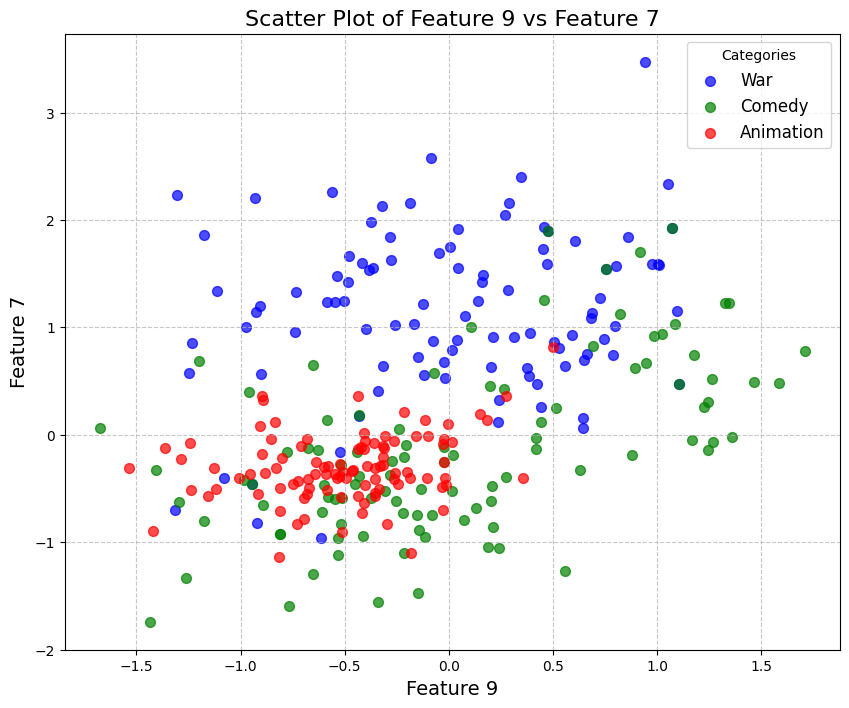

In [28]:
# Set k1 and k2 (the two visualization dimensions)
k1, k2 = 9, 7

# Initialize lists for the categories
cf1, cf2 = [], []
drf1, drf2 = [], []
df1, df2 = [], []

# Collect data for scatter plots
for i in range(100):
    # Child category
    cf1.append(V[child_indx[i]][k1])
    cf2.append(V[child_indx[i]][k2])
    
    # Drama category
    drf1.append(V[drama_indx[i]][k1])
    drf2.append(V[drama_indx[i]][k2])
    
    # Documentary category
    df1.append(V[documentary_indx[i]][k1])
    df2.append(V[documentary_indx[i]][k2])

# Plot the scatter plots
plt.figure(figsize=(10, 8))  # Set figure size
plt.scatter(cf1, cf2, label="War", alpha=0.7, s=50, color="blue")
plt.scatter(drf1, drf2, label="Comedy", alpha=0.7, s=50, color="green")
plt.scatter(df1, df2, label="Animation", alpha=0.7, s=50, color="red")

# Add labels, title, legend, and grid
plt.xlabel(f"Feature {k1}", fontsize=14)
plt.ylabel(f"Feature {k2}", fontsize=14)
plt.title(f"Scatter Plot of Feature {k1} vs Feature {k2}", fontsize=16)
plt.legend(title="Categories", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

# Save and show the plot
plt.savefig("scatter_plot_k9_k8.pdf", format="pdf")  # Save as PDF
print("Scatter plot saved as 'scatter_plot_k9_k8.pdf'.")
plt.show()


In [30]:
#Dummy user

iterations=10000


lambdaa=0.01
gamma=0.001
tau=0.1


U_dummy = np.random.normal(0, 1/(k**0.5), (1, k))
U_temp = np.concatenate([U, U_dummy], axis=0)
print(U_temp.shape)



user_biases_temp=np.append(user_biases,0)
print(user_biases_temp.shape)

i=len(user_biases_temp)-1

for r in range(iterations):
  tic=time.time()
  bias=0
  item_counter=0
  rated_by_user=[(271559,5)]
  u=U_temp[i].copy()

  for l in range(len(rated_by_user)):
      v=V[map_movie_to_index[rated_by_user[l][0]]].copy()
      bias=bias+lambdaa*(rated_by_user[l][1]-np.inner(u,v)-item_biases[map_movie_to_index[rated_by_user[l][0]]])
      item_counter=item_counter+1
  bias=bias/(lambdaa*item_counter+gamma)
  user_biases_temp[i]=bias



  S = np.zeros(shape=(k, k))
  R = np.zeros(shape=(k, 1))
  I = tau*np.identity(k)
  for l in range(len(rated_by_user)):
      v=V[map_movie_to_index[rated_by_user[l][0]]].copy()
      v=np.asmatrix(v)
      v=v.reshape(k,1)
      S=S+lambdaa*np.matmul(v,np.transpose(v))
      R=R+lambdaa*v*(rated_by_user[l][1]-user_biases_temp[i]-item_biases[map_movie_to_index[rated_by_user[l][0]]])
  U_temp[i]=np.transpose(np.matmul(np.linalg.inv(S+I),R))


(200949, 10)
(200949,)


In [ ]:
subset = movies_df[movies_df["movie_id"].isin(l)]

In [ ]:
subset

In [ ]:
mydata

In [ ]:
subset

In [ ]:
mydata

In [ ]:
#before
len(mydata)

In [ ]:
#after
len(mydata)

In [ ]:
rating_counts = mydata.groupby("movie_id").size().reset_index(name="rating_count")

# Filter movies with at least 100 ratings
popular_movies = rating_counts[rating_counts["rating_count"] >= 10]

# Merge with the movies dataset to get titles
subset = subset.merge(popular_movies, on="movie_id")

# Display the results
print(subset.head())
